# Simulating European power systems using open tools and data
This notebook is a sort of proof-of-concept for a simple workflow to simulate the hourly operations of all the European power systems using the following tools and data sources:
  - [PyPSA power system](https://pypsa.org/): one of the most used open power system models
  - [ENTSO-E Transparency Platform](https://transparency.entsoe.eu/): data for all the European power system operators
  - [Copernicus Climate Change Service data (C3S)](https://cds.climate.copernicus.eu/): climate and energy data for all the European countries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

# The power system model
import pypsa

# Two support static classes
from metenergy_data import *
from pypsa_support import *

To retrieve the ENTSO-E data you need to register to the ENTSO-E Transparency Platform to obtain an API key (free). See the Section 2 on [the official documentation](https://transparency.entsoe.eu/content/static_content/Static%20content/web%20api/Guide.html).

In [2]:
ENTSOE_API_KEY="<YOUR-KEY-HERE>"

## Loading climate-energy data from C3S
In this notebook we will use the following variables from the dataset [Climate and energy indicators for Europe from 1979 to present derived from reanalysis](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-energy-derived-reanalysis?tab=overview):
  - Air temperature (`TA`): to simulate the impact of air temperature on solar power
  - Solar radiation (`GHI`): to simulate the availability of solar power
  - Wind speed at 100m (`WS-_0100m`): to simulate the availability of wind power
  - Run-of-river hydropower generation (`HRO`): an estimation of the availability of hydropower from run-of-river plants

All the variables have been downloaded for the period 1979-2022. 
  

In [3]:
# Data downloaded from the Copernicus Climate Change Service (C3S) Climate Data Store (CDS)

# 2m air temperature
tmp = pd.read_csv('data/H_ERA5_ECMW_T639_TA-_0002m_Euro_NUT0_S197901010000_E202211302300_INS_TIM_01h_NA-_noc_org_NA_NA---_NA---_NA---.csv', 
skiprows=52,
parse_dates=True,
index_col='Date')

# Surface downwelling shortwave radiation
ssr = pd.read_csv('data/H_ERA5_ECMW_T639_GHI_0000m_Euro_NUT0_S197901010000_E202211302300_INS_TIM_01h_NA-_noc_org_NA_NA---_NA---_NA---.csv', 
skiprows=52,
parse_dates=True,
index_col='Date')

# Wind speed at 100m
ws = pd.read_csv('data/H_ERA5_ECMW_T639_WS-_0100m_Euro_NUT0_S197901010000_E202211302300_INS_TIM_01h_NA-_noc_org_NA_NA---_NA---_NA---.csv', 
skiprows=52,
parse_dates=True,
index_col='Date')

# Hydro power generation rivers
ror = pd.read_csv('data/H_ERA5_ECMW_T639_HRO_NA---_Euro_NUT0_S197901010000_E202210312300_CFR_TIM_01d_NA-_noc_org_NA_NA---_NA---_StRnF.csv', 
skiprows=61,
parse_dates=True,
index_col='Date')

# Solar radiation data can have some values smaller than zero (~1e-17) that can create issues in the modelling
ssr[ssr < 0] = 0

# Duplicating the data for Greece using the country code `GR` in addition to `EL` to be consistent with ENTSO-E data
tmp['GR'] = tmp['EL']
ws['GR']  = ws['EL']
ror['GR'] = ror['EL']
ssr['GR'] = ssr['EL']

## Setting up the simulation
Two important aspects are here decided: 
  - Which countries do we want to simulate? We can also simulate a subset of the European countries
  - Simulation period: we can select a data range (between `START` and `END`) for which we will use the observed energy & met data. 

In [4]:
# Which countries do we want to model? 
LIST_COUNTRIES = ['AT', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR', 'HR', 'HU', 'IE', 'IT',
'LV', 'LT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK', 'UK']
# Which period? 
START        = np.datetime64('2021-05-01 00:00')
END          = np.datetime64('2021-06-15 00:00')

YEAR         = np.datetime_as_string(START, unit='Y')

The data from the ENTSO-E Transparency Platform show some inconsistencies and in some cases, the generation capacity labelled `Other` is actually gas or biomass or something else. I have personally created this dictionary comparing the TP data with the ENTSO-E Statistical Factsheets and other robust data sources. 

In [5]:
other_map = {
    'AT':{'Biomass': 1.0},
    'SE':{'Biomass':0.3, 'Fossil Oil': 0.2, 'Fossil Gas': 0.5},
    'PL':{'Biomass':0.6, 'Fossil Oil': 0.4},
    'DE':{'Fossil Oil': 1.0},
    'FR':{ 'Fossil Gas': 1.0},
    'IE':{'Wind Onshore': 1.0},
    'IT':{'Solar': 1.0},
    'SK':{'Biomass': 1.0},
    'UK':{'Fossil Gas': 1.0}
    }

Here we create a PyPSA network using a set of hourly time-steps included in the simulated range.

In [6]:
NSTEPS = (END - START).astype('timedelta64[h]').astype(int)
print(f'{NSTEPS} to simulate')
n = pypsa.Network(snapshots = list(range(NSTEPS)))

1080 to simulate


For each country we perform the following steps:
  1. Load the hourly demand from ENTSO-E using `metenergy_data.get_demand_entsoe` 
  2. Extract the capacity factors from wind power, solar power and run-of-river from the C3S data
  3. Get the installed electric capacity using `metenergy_data.get_capacity_entsoe` and carrying out some ad hoc corrections
  4. Extracting the minimum generation and the ramping up/down of the generators using pre-computed data based on the ENTSO-E TP
  5. Creating the PyPSA generators using the function `pypsa_support.generators_from_entsoe` 
  6. Calculating the hydropower inflows and other hydropower characteristics if hydropower is part of the country energy mix
  7. Creating the storage units using `pypsa_support.stores_from_entsoe`
  8. Creating all the PyPSA components needed for the simulation


In [7]:
for COUNTRY in LIST_COUNTRIES:
    print(f"Adding {COUNTRY}...")
    # Demand / Load ---------------------------------------------------------------------------------------------------------------------
    dem       = metenergy_data.get_demand_entsoe(COUNTRY, timeline = pd.date_range(start = START, end = END, tz = 'UTC'), MY_API_KEY=ENTSOE_API_KEY)
    dem.index = dem.index.tz_convert(None)

    # Wind (both onshore and offshore) ---------------------------------------------------------------------
    wp = (
        metenergy_data
        .get_wind_cf(ws = ws.loc[YEAR, COUNTRY])  # type: ignore
        .loc[dem.index]
    )

    # Solar -------------------------------------------------------------------------------------------------------------------
    sp = (
        metenergy_data
        .get_PV_cf(tmp = tmp.loc[YEAR, COUNTRY], ssr = ssr.loc[YEAR, COUNTRY].groupby(level = 0).last())  # type: ignore
        .loc[dem.index]
    ) 

    # Generation capacity -----------------------------------------------------------------------------------------------------
    cap_this = metenergy_data.get_capacity_entsoe(zone = COUNTRY, year = int(YEAR), MY_API_KEY=ENTSOE_API_KEY)
    # Keep only values with > 50 MW: in this way we remove types with no or negligible power
    cap_this = cap_this.loc[:, (cap_this > 50).any(axis = 0)]
    # Ad hoc corrections to fix known issues in the Transparency Platform
    if COUNTRY in ['CZ', 'DE', 'PL']:
        # For these countries the storage level is not reported although they have hydropower capacity
        cap_this = cap_this.drop(columns = 'Hydro Water Reservoir')
    elif COUNTRY == 'SK':
        # For SK we assume that all the hydropower is run-of-river
        cap_this['Hydro Run-of-river and poundage'] = cap_this['Hydro Run-of-river and poundage'] + cap_this['Hydro Water Reservoir']
        cap_this = cap_this.drop(columns = 'Hydro Water Reservoir')
        
    # Replacing `Other` from ENTSO-E TP with country-specific generation ----------------------------------------------------
    # Only for capacities above 500 M
    if 'Other' in cap_this.columns:
        if cap_this['Other'].values[0] > 500:
            for key in other_map[COUNTRY]:
                if key in cap_this.columns:
                    cap_this[key] = cap_this[key] + cap_this['Other']*other_map[COUNTRY][key]
                else:
                    cap_this[key] = cap_this['Other']*other_map[COUNTRY][key]

            cap_this = cap_this.drop(columns = ['Other'])
    # Load min gen -----------------------------------------------------------------------------------------------------------
    # This is the minimum generation for each area and production type observed in the TP in 2020-2022
    pmin = pd.read_csv('data/mingen-2020_2022.csv')
    pmin = pmin.loc[pmin.MapCode == COUNTRY]
    # Load ramping -----------------------------------------------------------------------------------------------------------
    # Ramping (diff between production at time t and t-1) up and down observed in the TP in 2020-2022
    ramping = pd.read_csv('data/ramping-2020_2022.csv')
    ramping = ramping.loc[ramping.MapCode == COUNTRY]

    # (PYPSA) Generators -----------------------------------------------------
    gen = (
        pypsa_support.generators_from_entsoe(cap_this, pmin, ramping, template = pd.read_csv('data/entsoe_template_generators.csv'))
        .query("p_nom > 0")
    )
    # setting p_min to zero for RES ---------------------------------------------------------------------------------------
    gen.loc[gen['carrier'] == 'onwind', 'p_min_pu']  = 0
    gen.loc[gen['carrier'] == 'offwind', 'p_min_pu'] = 0
    gen.loc[gen['carrier'] == 'solar', 'p_min_pu']   = 0
    gen.loc[gen['carrier'] == 'ror', 'p_min_pu']     = 0

    # Creating the names of the generators ---------------------------------------------------------------------------------
    gen['name'] = "gen_"+ gen['name'] + "_" + COUNTRY
    # Adding the bus -------------------------------------------------------------------------------------------------------
    gen['bus']  = COUNTRY

    # Add Loss-of-load stack generator ------------------------------------------------------------------------------------------------
    gen = pd.concat([ gen, pd.DataFrame(
        data = {'name': f'gen_LoL_{COUNTRY}', 'carrier': 'LoL', 'p_nom': 1e5, 'efficiency': 1.0, 'marginal_cost': 1e3, 
        'ramp_limit_up': 1.0,'ramp_limit_down': 1.0, 'p_min_pu': 0,
        'bus': COUNTRY}, 
        index = [0])
        ])
    # Setting the index ---------------------------------------------------------------------------------------------------------------
    gen.index = gen['name']  # type: ignore
    # If hydropower is part of the capacity mix we calculate the inflow
    if 'Hydro Water Reservoir' in cap_this.columns:
        # Inflow ----------------------------------------------------------------------------------------------------------------------
        # The inflow is the quantity of energy that can be either stored or used to generate electricity. To calculate the inflow we 
        # add 10 days to the date range to include all the needed time-steps (ENTSO-E data on hydropower is weekly)
        inflow = metenergy_data.get_inflow_entsoe(
            zone = COUNTRY, 
            timeline = pd.date_range(
                start = START - np.timedelta64(10,'D'), 
                end = END + np.timedelta64(10,'D'), tz = 'UTC') ,
            MY_API_KEY=ENTSOE_API_KEY
            )
        # Setting the negative values to zero
        inflow.loc[inflow['inflow'] < 0 , 'inflow'] = 0

        # Remove the timezone
        if inflow.index.tz is not None:
            inflow.index = inflow.index.tz_convert(None)

        # Converting inflow from weekly to hourly
        this_inflow = inflow.resample('H').ffill().loc[dem.index, 'inflow']
        # Dividing the weekly values (replicated with `ffill`) for 168
        this_inflow = this_inflow / 168
        # Transforming `this_inflow` into a Pandas data frame
        this_inflow = pd.DataFrame(data = {'sto_hydro_'+COUNTRY: this_inflow.values})
        # min storage (hydro) -----------------------------------------------------------------------------------------------
        # The data structure `inflow` contains also the storage level
        min_stor = inflow.resample('H').ffill().loc[dem.index, 'storage']  
        # Transforming `min_stor` into a Pandas data frame
        min_stor = pd.DataFrame(data = {'sto_hydro_' + COUNTRY: min_stor.values})
        # The minimum storage is used as a guiding curve, in other words used as lower bound of the hydropower storage
        # levels simulated by PyPSA. To avoid constraining too much the simulation, we set to 0 all the values between an interval
        # of 168. In other words, the lower bound works one hour each week.  
        min_stor.loc[(min_stor.index % (24 * 7)) != 0] = 0 
    # (PyPSA) Storage units --------------------------------------------------------------------------------------------------
    # Creating and setting the name, bus and other params
    sto = pypsa_support.stores_from_entsoe(cap_this)
    sto['name'] = "sto_"+ sto['name'] + "_" + COUNTRY
    sto['bus'] = COUNTRY
    sto['cyclic_state_of_charge_per_period'] = False
    sto.index = sto['name']
    
    # If there is a hydropower generator...
    if 'sto_hydro_'+COUNTRY in sto.index:
        # ...we set the initial charge to the first step of the storage level + the first week of inflow
        sto.loc['sto_hydro_'+COUNTRY, 'state_of_charge_initial'] = inflow['storage'][0] + inflow['Hydro Water Reservoir'][0]
        # ... we set the maximum number hours of storage converting the maximum storage level in hours using the hydropower capacity
        sto.loc['sto_hydro_'+COUNTRY, 'max_hours'] = (inflow['storage'] + inflow['Hydro Water Reservoir']).max() / sto.loc['sto_hydro_'+COUNTRY, 'p_nom']

    # The run-of-river daily capacity factor is converted to hourly -----------------------------------------------------------------------------
    this_ror = ror.loc[YEAR, COUNTRY].resample('H').ffill().loc[dem.index]

    # Generators maximum output for PyPSA `p_max_pu``
    # Note: onshore and offshore wind are assumed the same
    pu = pd.DataFrame(
        data = {
            f'gen_onwind_{COUNTRY}' : wp['wp'].values,
            f'gen_offwind_{COUNTRY}': wp['wp'].values,
            f'gen_solar_{COUNTRY}'  : sp['sp'].values,
            f'gen_ror_{COUNTRY}'    : this_ror.values
        }
    )

    # Creating the hourly demand ---------------------------------------------------------------------------------------------------------------
    load = pd.DataFrame(
        data = {f'demand_{COUNTRY}': dem['Actual Load'].values}
    )

    # Adding the bus to PyPSA ------------------------------------------------------------------------------------------------------------------
    n.madd("Bus", [COUNTRY])
    # Adding the components --------------------------------------------------------------------------------------------------------------------
    n.import_components_from_dataframe(gen, 'Generator')
    n.import_components_from_dataframe(sto, 'StorageUnit')
    n.import_components_from_dataframe(pd.DataFrame(
        data = {'name': f'demand_{COUNTRY}', 'bus': COUNTRY, 'p_set': np.nan},
        index = [f'demand_{COUNTRY}']
    ), 'Load')
    # Adding the `p_max_pu` for the added generators -------------------------------------------------------------------------------------------
    n.import_series_from_dataframe(pu[pu.columns.intersection(gen['name'])], 'Generator', 'p_max_pu')
    # Adding the demand time-series ------------------------------------------------------------------------------------------------------------
    n.import_series_from_dataframe(load, 'Load', 'p_set')
    # For hydropower (if any)
    # 1. Adding inflow and minimum storage
    # 2. The hydropower modelled as `StorageUnit` is converted to a more realistic modelisation with links and stores as described here https://pypsa.readthedocs.io/en/latest/examples/replace-generator-storage-units-with-store.html
    if 'Hydro Water Reservoir' in cap_this.columns:
        n.import_series_from_dataframe(this_inflow, 'StorageUnit', 'inflow')
        n.import_series_from_dataframe(min_stor, 'StorageUnit', 'state_of_charge_set')

        selgen = n.storage_units.loc['sto_hydro_'+COUNTRY]
        bus_name   = "{} {}".format(selgen["bus"], selgen["carrier"])
        store_name = "{} store {}".format('sto_hydro_'+COUNTRY, selgen["carrier"])

        n.add("Bus", bus_name, carrier=selgen["carrier"])

        n.add(
        "Link",
        'hydro_to_grid_'+COUNTRY,
        bus0=bus_name,
        bus1=selgen["bus"],
        p_nom=selgen["p_nom"] / selgen["efficiency_dispatch"],
        p_max_pu=1,
        p_min_pu=0,
        marginal_cost=selgen["marginal_cost"] * selgen["efficiency_dispatch"],
        efficiency=selgen["efficiency_dispatch"],
        )

        n.add(
        "Store",
        store_name,
        bus=bus_name,
        e_nom=selgen['p_nom'] * selgen['max_hours'],
        e_nom_extendable=False,
        e_initial = selgen['state_of_charge_initial']*1,
        e_min_pu = (n.storage_units_t.state_of_charge_set['sto_hydro_'+COUNTRY]) / (selgen['p_nom'] * selgen['max_hours']),
        e_max_pu =1.0
        )

        # inflow from a variable generator, which can be curtailed (i.e. spilled)
        inflow_max = n.storage_units_t.inflow['sto_hydro_'+COUNTRY].max()

        if inflow_max == 0.0:
            inflow_pu = 0.0
        else:
            inflow_pu = n.storage_units_t.inflow['sto_hydro_'+COUNTRY] / inflow_max

        n.add(
            "Generator",
            'inflow_hydro_' + COUNTRY,
            bus=bus_name,
            carrier="inflow",
            p_nom=inflow_max,
            p_max_pu=inflow_pu,
            ramp_limit_up = 1,
            ramp_limit_down = 1
        )

        n.add(
            "Generator",
            'LoL_inflow_hydro_' + COUNTRY,
            bus=bus_name,
            carrier="LoL_inflow",
            p_nom=1e6,
            p_max_pu=1,
            ramp_limit_up = 1,
            marginal_cost = 2000,
            ramp_limit_down = 1
        )

        n.remove("StorageUnit", 'sto_hydro_'+COUNTRY)


Adding AT...
Adding BE...
Adding BG...
Adding CH...
Adding CZ...
Adding DE...
Adding DK...
Adding EE...
Adding ES...
Adding FI...
Adding FR...


Adding GR...
Adding HR...
Adding HU...
Adding IE...


Adding IT...
Adding LV...


Adding LT...
Adding NL...
Adding NO...
Adding PL...
Adding PT...
Adding RO...


Adding RS...
Adding SE...
Adding SI...
Adding SK...
Adding UK...


            1075, 1076, 1077, 1078, 1079],
           dtype='int64', name='snapshot') are missing from p_max_pu of Generator. Filling with default value '1.0'
            1075, 1076, 1077, 1078, 1079],
           dtype='int64', name='snapshot') are missing from p_set of Load. Filling with default value '0.0'


In [8]:
# dem.head()
# dem.index.to_series().diff().plot()
# pmin.query('ProductionType == "Nuclear"')
# n.generators
ramping

,MapCode,ProductionType,max_up,max_down,carrier


# Adding the inter-connections
The Net Transfer Capacity (NTC) of the cross-border electricity interconnectors has been calculated using the Physical Flows data on the ENTSO-E TP. For each interconnector between two countries, we have used the maximum observed value in the period 2020-2022.

In [9]:
# Add links
list_links = (
    pd.read_csv('data/ntc-2020_2022.csv')
    .query('year == 2022')
)
list_links = list_links.loc[ list_links['to'].isin(LIST_COUNTRIES) & list_links['from'].isin(LIST_COUNTRIES)]

n.madd(
    "Link", 
    'link_' + list_links['from'] + '_' + list_links['to'],
    bus0 = list_links['from'].values,
    bus1 = list_links['to'].values,
    p_min_pu = 0,
    p_max_pu = 1,
    p_nom = list_links['max'].values
)

Index(['link_DE_CH', 'link_AT_HU', 'link_RS_HU', 'link_HU_RS', 'link_HU_SK',
       'link_ES_FR', 'link_RO_BG', 'link_SK_CZ', 'link_CZ_SK', 'link_BE_UK',
       ...
       'link_GR_BG', 'link_DE_PL', 'link_FR_CH', 'link_SK_PL', 'link_NO_DK',
       'link_GR_IT', 'link_FI_SE', 'link_CH_FR', 'link_SI_HU', 'link_HU_SI'],
      dtype='object', length=112)

Here we fill potential NAs and perform a [consistency check](https://pypsa.readthedocs.io/en/latest/api_reference.html#pypsa.Network.consistency_check)

In [10]:
n.generators_t.p_max_pu.fillna(1, inplace=True)
n.generators_t.p_min_pu.fillna(0, inplace=True)
n.stores_t.e_min_pu.fillna(0, inplace=True)
# some demand values can be zero creating infeasibilities
n.loads_t.p_set = n.loads_t.p_set.replace(to_replace=0, method='ffill')

n.consistency_check()

## Running the simulation
Here using the `coin-cbc` solver we simulate the network to find the optimal solution.

In [11]:
n.lopf(snapshots = range(NSTEPS), pyomo = False, solver_name = 'cbc')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 2.49s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.11e+10


('ok', 'optimal')

PyPSA provides some [statistics](https://pypsa.readthedocs.io/en/latest/api_reference.html#module-pypsa.statistics). Here for example the curtailment. 

In [12]:
n.statistics.curtailment()

             carrier   
Generator    CCGT             0.000000
             LoL              0.000000
             LoL_inflow       0.000000
             biomass          0.000000
             coal             0.000000
             geothermal       0.000000
             inflow        7088.698595
             lignite          0.000000
             nuclear          0.000000
             offwind         88.697221
             oil              0.000000
             onwind         114.597357
             ror              0.000098
             solar            0.000115
StorageUnit  PHS              0.000000
Name: Curtailment, dtype: float64

## Plotting
Using the function defined in `pypsa_support` we can show the hourly dispatching

/home/matteo/miniconda3/envs/pypsa-eur/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/matteo/miniconda3/envs/pypsa-eur/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/matteo/miniconda3/envs/pypsa-eur/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


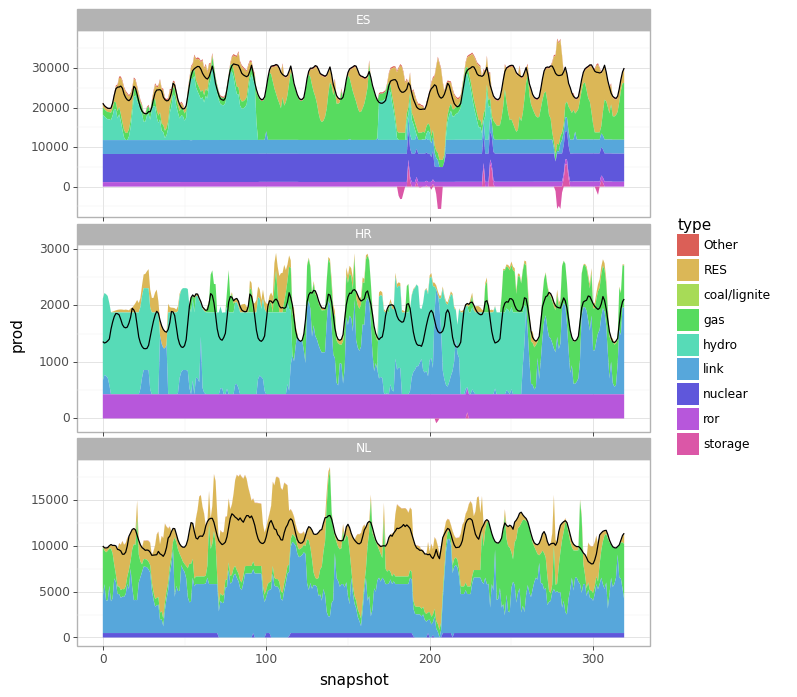

<ggplot: (8754811332946)>

In [18]:
# pypsa_support.dispatch_plot(n, ['ES', 'HR', 'BE', 'RO'], range(320))
pypsa_support.dispatch_plot(n, ['NL', 'ES', 'HR'], range(320))

A last simple plot might be the hourly marginal cost on the entire simulated area weighted by the demand.

<AxesSubplot:xlabel='snapshot'>

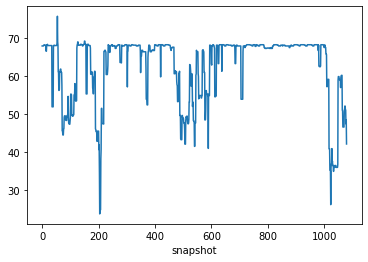

In [19]:
mp = n.buses_t['marginal_price'].loc[:, ~n.buses_t['marginal_price'].columns.str.contains('hydro')]
sl = n.loads_t.p.sum()
sl.index = sl.index.str.replace('demand_', '')
mpeu = (mp * sl).sum(axis = 1) / sl.sum()
mpeu.plot()

In [2]:
n = pypsa.Network()
n.madd("Bus", ["b0", "b1"])
n.add("Link", "l1", bus0="b0", bus1="b1", p_nom=10)
n.add("Load", "b0", bus="b0", p_set= 5)
n.add("Load", "b1", bus="b1", p_set= 4)
n.madd("Generator", ["g0", "g1"], bus=["b0", "b1"], p_nom= [5,8],
marginal_cost= [0, 200])
n.optimize(solver_name="highs")

INFO:linopy.model: Solve linear problem using Highs solver


AssertionError: Solver highs not installed